In [1]:
from __future__ import division
import numpy as np 
import matplotlib.ticker
from scipy.special import factorial
import pylab as pl
import random
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
from support import Support
from node import Node

### Create task class

In [3]:
# Judgment of Recency
class jor:

    def __init__(self, Nt=1500, i_dt=0.001, i_k=8, i_buff_len=100, i_g=1, i_tstr_min=0.05, i_tstr_max=2, e_thr = 0.01):
        
        """
        Initialize JOR task
        
        Keyword arguments:
        Nt -- number of time points 
        i_dt -- time step (for input nodes)
        i_k -- value of k (for input nodes)
        i_buff_len -- number of taustar nodes (for input nodes)
        i_g -- parameter g (determinizes scaling of tilde{f} - g=1->equal amplitude, g=0->power-law decay of amplitude)
        i_tstr_min -- smallest taustar (for input nodes)
        i_tstr_max -- largest taustar (for input nodes)
        
        e_thr -- evidence accumulator threshols
        """
        
        self.Nt = Nt 
        
        # Input parameters
        self.i_dt = i_dt
        self.i_k = i_k
        self.i_buff_len = i_buff_len
        self.i_g = i_g
        self.i_tstr_min = i_tstr_min
        self.i_tstr_max = i_tstr_max
        
        
        # JOR specific parameters
        self.probe_size = 2 # how many items does the probe stimulus contain
        self.acc_type = 2 # two independent accumulators
        
        self.e_thr = e_thr
        
        self.lag = []
        self.alpha_array = np.zeros(self.Nt)
        self.lags = []
        self.reaction_times = []
        self.answers = []
        self.reaction_time = 0.
        

### Update memory at every time step

In [4]:
def update_input_memory(p_n, time_index):
    for name in p_n.input_names:
        p_n.inputs[p_n.input_names.index(name)].support.update(
            time_index, np.max([0, p_n.inputs[p_n.input_names.index(name)].value[time_index] - 
        p_n.inputs[p_n.input_names.index(name)].value[time_index-1]]))    

### Plot stuff

In [5]:
%matplotlib inline
#%matplotlib notebook
pl.ion()

def plot_inputs(p_n):
    for idx, name in enumerate(p_n.input_names):
        _ = pl.subplot(len(p_n.input_names), 1, idx+1)
        _ = pl.plot(p_n.inputs[p_n.input_names.index(name)].value, color='blue')
        
def plot_memory(p_n):
    k = p_n.inputs[0].support.k
    for idx, name in enumerate(p_n.input_names):
        _ = pl.subplot(len(p_n.input_names), 1, idx+1)
        #_ = pl.scatter(time_index, inputs[input_names.index(name)].support.til_f[k:-k,time_index], color='blue')
        _ = pl.plot(p_n.inputs[p_n.input_names.index(name)].support.til_f[k:-k,:].T, color='blue')
        
def set_axes(ax, idx):
    if idx == 0:
        ax.set_yticks(np.arange(0,1)) 
        #ax.set_yticklabels([0])
    else:
        ax.set_yticks(np.arange(0)) 
        #ax.set_yticklabels([0])
    ax.tick_params(labelsize=18)
        
def plot_inputs_memory(p_n):
    fig = pl.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
    k = p_n.inputs[0].support.k
    for idx, name in enumerate(p_n.input_names):
        ax = pl.subplot(3, len(p_n.input_names), idx+1)
        set_axes(ax, idx)
        if idx == 3:
            ax.set_title(r'$\bf{Inputs}$' + ' \n %s'%(p_n.input_names[idx]), fontsize=20)
        else:
            ax.set_title(p_n.input_names[idx], fontsize=20)
        ax.set_xticks(np.arange(0)) 
        ax.set_xticklabels([])
        ax.plot(p_n.inputs[p_n.input_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(p_n.input_names), idx+1+len(p_n.input_names))
        set_axes(ax, idx)
        if idx == 3:
            ax.set_title(r'$\bf{Laplace\ transform}$', fontsize=20)
        ax.set_xticks(np.arange(0)) 
        ax.set_xticklabels([])
        ax.plot(p_n.inputs[p_n.input_names.index(name)].support.F[k:-k:10,:].T, color='blue')
        ax = pl.subplot(3, len(p_n.input_names), idx+1+2*len(p_n.input_names))
        ax.plot(p_n.inputs[p_n.input_names.index(name)].support.til_f[k:-k:10,:].T, color='blue')
        set_axes(ax, idx)
        if idx == 3:
            ax.set_title(r'$\bf{Inverse\ Laplace\ transform}$', fontsize=20)
        ax.set_xlabel('Time', fontsize=18)
        #pl.savefig("JOR_input_memory_v1.pdf", bbox_inches='tight')
        

### Generate radom data

In [6]:
def generate_jor_data(p_n):
    p_n.input_names = ['R', 'Y', 'T', 'X', 'Q', 'G', 'K']
    #random.shuffle(p_n.input_names)
    #p_n.probes = random.sample(p_n.input_names, 2)
    # make probes in order (makes it easier to compute the accuracy)
    p_n.probes = [p_n.input_names[i] for i in sorted(random.sample(range(len(p_n.input_names)), 2))]
    #p_n.probes = ['R','Y'] # for testing
    p_n.lag = []
    p_n.lag.append(len(p_n.input_names)-p_n.input_names.index(p_n.probes[0]))
    p_n.lag.append(len(p_n.input_names)-p_n.input_names.index(p_n.probes[1]))
    p_n.inputs = []
    for name in p_n.input_names:
        _ = p_n.inputs.append(Node(name, tstr_min=p_n.i_tstr_min, tstr_max=p_n.i_tstr_max, 
                                            buff_len=p_n.i_buff_len, k=p_n.i_k, 
                                            dt=p_n.i_dt, g=p_n.i_g, Nt=p_n.Nt))

    # Zero all inputs
    for name in p_n.input_names:
        p_n.inputs[p_n.input_names.index(name)].value = np.zeros(p_n.Nt)
    # Put the letters every x time steps
    for input_no, input_name in enumerate(p_n.input_names):
        p_n.inputs[p_n.input_names.index(input_name)].value[(input_no+1)*100] = 1#*random.uniform(0.1, 1)
    # Add two probes at the end
    for probe_no, probe_name in enumerate(p_n.probes):
        p_n.inputs[p_n.input_names.index(probe_name)].value[(input_no+1)*100+100] = 1


### Run the simulation

In [7]:
p_n = jor(e_thr=0.005) #task name

p_n.lags = []
p_n.reaction_times = []
p_n.answers = []

ntrials = 5000
probe_time = 800 # when probe is presented

for trial in range(ntrials):
    noise_factor_l = random.uniform(0.15, 1.85)
    noise_factor_r = random.uniform(0.15, 1.85)
    #if trial % 10 == 0:
        #print(trial)
        #print('dumping')
        #dump(p_n, filename='p_n_JOR_tmp.gz')
    generate_jor_data(p_n) # generates the data for this trial
    # Initialize
    ev_l = 0.
    ev_r = 0.
    p_n.ev_left = 0
    p_n.ev_right = 0
    # Present the list
    for time_index in range(2,probe_time):
        update_input_memory(p_n, time_index)
    # Scan the memory slot by slot
    for g in range(p_n.i_buff_len):
        for name in p_n.input_names:
            if name == p_n.probes[0]:
                ev_l_tmp = p_n.inputs[p_n.input_names.index(p_n.probes[0])].support.til_f[p_n.i_k+g, time_index]
            if name == p_n.probes[1]:
                ev_r_tmp = p_n.inputs[p_n.input_names.index(p_n.probes[1])].support.til_f[p_n.i_k+g, time_index]
        #ev_l = ev_l + ev_l_tmp
        #ev_r = ev_r + ev_r_tmp
        ev_l = ev_l + ev_l_tmp*noise_factor_l
        ev_r = ev_r + ev_r_tmp*noise_factor_r
        if ev_l > p_n.e_thr or ev_r > p_n.e_thr:
            if ev_l > ev_r:
                p_n.ev_left = 1
            else:
                p_n.ev_right = 1
            break
    p_n.reaction_time = g # If not enough evidence before time limit
    # Append the results
    p_n.lags.append(p_n.lag)
    p_n.reaction_times.append(p_n.reaction_time)
    if p_n.ev_right:
        p_n.answers.append(0) # incorrect
    elif p_n.ev_left:
        p_n.answers.append(1) # corect
    else:
        p_n.answers.append(2) # time out - no answer

### Visualize results of the last trial

<Figure size 432x288 with 0 Axes>

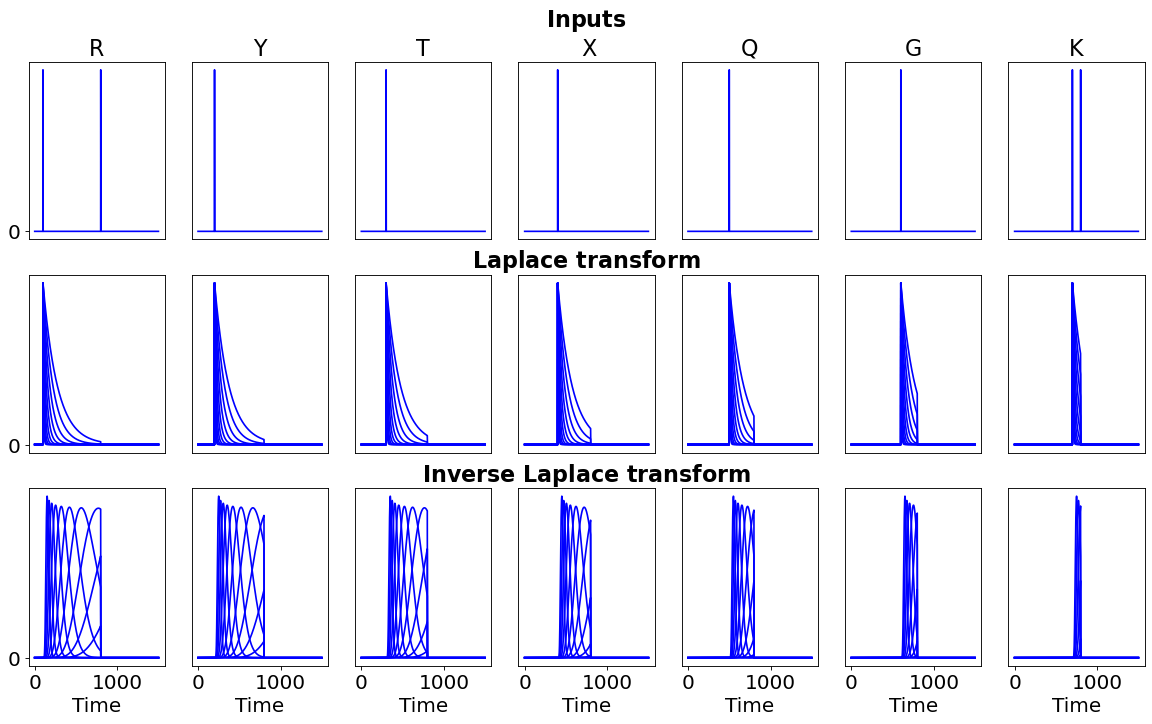

In [8]:
pl.tight_layout()

plot_inputs_memory(p_n)

### Visualize aggregate results 

In [9]:
def make_jor_figures(p_n):
    
    # covert things into np arrays
    rt = np.array(p_n.reaction_times)
    lags = np.array(p_n.lags)
    answers = np.array(p_n.answers)
    # lag 0 less recent
    # lag 1 more recent
    # answer 0 correct
    # answer 1 incorect
    
    
    # lag vs RT - correct
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    rt_mean = np.zeros((7,7))
    rt_std = np.zeros((7,7))
    for j in range(7): # across more recent
        for i in range(7): # across less recent
            rt_mean[i,j] = np.mean(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==0))])
            rt_std[i,j] = np.std(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==0))])
        ax.errorbar(np.arange(1, 8), rt_mean[:,j], rt_std[:,j], marker='.', color=str(j/6.))
    pl.ylabel('Response time [au]')
    pl.xlabel('Lag of a less recent item') 
    pl.title('Correct responses')
    #pl.savefig("JOI_less_recent_lag_vs_RT_v1.pdf", bbox_inches='tight')
    pl.show()
    
    
    # lag vs RT - incorrect
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    rt_mean = np.zeros((7,7))
    rt_std = np.zeros((7,7))
    for j in range(7): # across more recent
        for i in range(7): # across less recent
            rt_mean[i,j] = np.mean(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==1))])
            rt_std[i,j] = np.std(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==1))])
        ax.errorbar(np.arange(1, 8), rt_mean[:,j], rt_std[:,j], marker='.', color=str(j/6.))
    pl.ylabel('Response time [arbitrary units]')
    pl.xlabel('Lag of a less recent item') #Lag of less recent item
    pl.title('Incorrect responses')
    #pl.savefig("JOR_inc_lag_vs_RT_v1.pdf", bbox_inches='tight')
    pl.show()
    
    
    
    # Less recent lag vs accuracy
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    acc_mean = np.empty((7,7))
    acc_mean[:] = np.nan
    for j in range(7): # across more recent
        for i in range(7): # across less recent
            correct = np.sum((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==0))
            total = np.sum((lags[:,0]==i+1) & (lags[:,1]==j+1))
            if total > 0:
                acc_mean[i,j] = correct/total
        ax.plot(np.arange(1, 8), acc_mean[:,j], marker='.', color=str(j/6.))
    pl.ylabel('Accuracy')
    pl.xlabel('Lag of a less recent item')
    #pl.savefig("JOR_acc_lag_vs_RT_v1.pdf", bbox_inches='tight')
    pl.show()
    
    
    # lag vs more recent RT - correct only
    rt_mean = np.zeros((8))
    rt_std = np.zeros((8))
    for i in range(8):
        rt_mean[i] = np.mean(rt[np.where((lags[:,1]==i+1) & (answers==0))])
        rt_std[i] = np.std(rt[np.where((lags[:,1]==i+1) & (answers==0))])
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    ax.plot(np.arange(1, 9), rt_mean, '.', color='k')
    ax.errorbar(np.arange(1, 9), rt_mean, rt_std, marker='.', fmt='none', ecolor='k')
    pl.ylabel('Response time (au)')
    pl.xlabel('Lag of a more recent item') #Lag of more recent item
    log_lags_correct = np.log(np.squeeze(lags[np.where((lags[:,1]>1) & (answers==0)),1]))
    rt_correct = rt[np.where((lags[:,1]>1) & (answers==0))]
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_lags_correct, rt_correct)
    lag_times = np.arange(1,7)
    ax.plot(lag_times, slope*np.log(lag_times) + intercept, color='k')
    ax.set_xscale("log", nonposx='clip')
    ax.set_xticks(np.arange(1,7)) 
    ax.set_xticklabels([str(i) for i in range(1,7)])
    #ax.set_ylim(-500, 1800)
    #ax.set_yticklabels([])
    pl.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    pl.savefig("JOI_more_recent_lag_vs_RT_v1.pdf", bbox_inches='tight')
    pl.savefig("JOI_more_recent_lag_vs_RT_v1.png", bbox_inches='tight')
    pl.show()
    
    # cummulative plots
    for i in range(7):
        #a = np.array(p_n.reaction_times)[np.where(np.array(p_n.lags)==i+2)[0]]
        a = rt[np.where((lags[:,1]==i+1) & (answers==0))]
        N = len(a)
        #if N>0:
        #    a = np.random.normal(loc=np.mean(a), scale=p_n.s_sigma_ad+p_n.e_thr*np.mean(a), size=len(a))
        X2 = np.sort(a)
        F2 = np.array(range(N))/float(N)
        pl.plot(X2, F2)
    #ax.tick_params(labelsize=14)
    #pl.xlabel('Response time (arbitrary units)', fontsize=14)
    #pl.ylabel('Cumulative probability', fontsize=14)

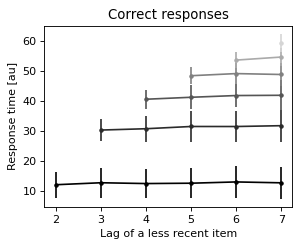

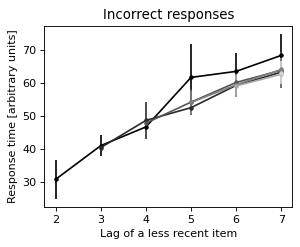

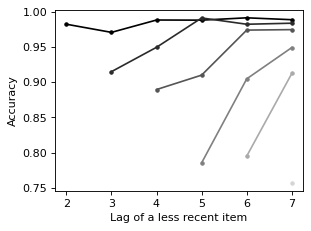

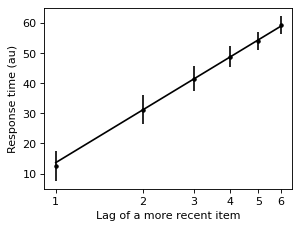

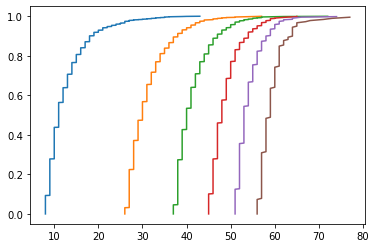

In [10]:
make_jor_figures(p_n)

In [11]:
def make_jor_flipped_figures(p_n):
    
    # covert things into np arrays
    rt = np.array(p_n.reaction_times)
    lags = np.array(p_n.lags)
    answers = np.array(p_n.answers)
    # lag 0 less recent
    # lag 1 more recent
    # answer 0 correct
    # answer 1 incorect
    
    
    # lag vs RT - correct
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    rt_mean = np.zeros((7,7))
    rt_std = np.zeros((7,7))
    for j in range(7): # across more recent
        for i in range(7): # across less recent
            rt_mean[i,j] = np.mean(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==0))])
            rt_std[i,j] = np.std(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==0))])
        ax.errorbar(np.arange(1, 8), rt_mean[:,j], rt_std[:,j], marker='.', color=str(j/6.))
    pl.ylabel('Response Time [au]', fontsize=14)
    pl.xlabel('Lag to the less recent probe', fontsize=14) 
    #pl.title('Correct responses')
    ax.invert_xaxis()
    pl.xticks(np.arange(7,1,-1), np.arange(-7,-1))
    pl.savefig("JOR_less_recent_lag_vs_RT_noise2.pdf", bbox_inches='tight')
    pl.show()
    
    
    # lag vs RT - incorrect
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    rt_mean = np.zeros((7,7))
    rt_std = np.zeros((7,7))
    for j in range(7): # across more recent
        for i in range(7): # across less recent
            rt_mean[i,j] = np.mean(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==1))])
            rt_std[i,j] = np.std(rt[np.where((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==1))])
        ax.errorbar(np.arange(1, 8), rt_mean[:,j], rt_std[:,j], marker='.', color=str(j/6.))
    pl.ylabel('Response Time [au]', fontsize=14)
    pl.xlabel('Lag to the less recent probe', fontsize=14) #Lag of less recent item
    #pl.title('Incorrect responses')
    ax.invert_xaxis()
    pl.xticks(np.arange(7,1,-1), np.arange(-7,-1))
    pl.savefig("JOR_inc_lag_vs_RT_noise2.pdf", bbox_inches='tight')
    pl.show()
    
    
    
    # Less recent lag vs accuracy
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    acc_mean = np.empty((7,7))
    acc_mean[:] = np.nan
    for j in range(7): # across more recent
        for i in range(7): # across less recent
            correct = np.sum((lags[:,0]==i+1) & (lags[:,1]==j+1) & (answers==0))
            total = np.sum((lags[:,0]==i+1) & (lags[:,1]==j+1))
            if total > 0:
                acc_mean[i,j] = correct/total
        ax.plot(np.arange(1, 8), acc_mean[:,j], marker='.', color=str(j/6.))
    pl.ylabel('Accuracy', fontsize=14)
    pl.xlabel('Lag to the less recent probe', fontsize=14)
    ax.invert_xaxis()
    pl.xticks(np.arange(7,1,-1), np.arange(-7,-1))
    pl.savefig("JOR_acc_lag_vs_RT_noise2.pdf", bbox_inches='tight')
    pl.show()
    
    
    # lag vs more recent RT - correct only
    rt_mean = np.zeros((8))
    rt_std = np.zeros((8))
    for i in range(8):
        rt_mean[i] = np.mean(rt[np.where((lags[:,1]==i+1) & (answers==0))])
        rt_std[i] = np.std(rt[np.where((lags[:,1]==i+1) & (answers==0))])
    fig = pl.figure(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    ax = pl.subplot(111)
    ax.plot(np.arange(1, 9), rt_mean, '.', color='k')
    ax.errorbar(np.arange(1, 9), rt_mean, rt_std, marker='.', fmt='none', ecolor='k')
    pl.ylabel('Response Time (au)', fontsize=14)
    pl.xlabel('Lag to the more recent probe', fontsize=14) #Lag of more recent item
    log_lags_correct = np.log(np.squeeze(lags[np.where((lags[:,1]>1) & (answers==0)),1]))
    rt_correct = rt[np.where((lags[:,1]>1) & (answers==0))]
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_lags_correct, rt_correct)
    lag_times = np.arange(1,7)
    ax.plot(lag_times, slope*np.log(lag_times) + intercept, color='k')
    ax.set_xscale("log", nonposx='clip')
    ax.set_xticks(np.arange(1,7)) 
    #ax.set_xticklabels([str(i) for i in range(1,6)])
    #ax.set_ylim(-500, 1800)
    #ax.set_yticklabels([])
    pl.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.invert_xaxis()
    pl.xticks(np.arange(6,0,-1), np.arange(-6,0))
    pl.savefig("JOR_more_recent_lag_vs_RT_noise2.pdf", bbox_inches='tight')
    pl.savefig("JOR_more_recent_lag_vs_RT_noise2.png", bbox_inches='tight')
    pl.show()
    
    # cummulative plots
    for i in range(7):
        #a = np.array(p_n.reaction_times)[np.where(np.array(p_n.lags)==i+2)[0]]
        a = rt[np.where((lags[:,1]==i+1) & (answers==0))]
        N = len(a)
        #if N>0:
        #    a = np.random.normal(loc=np.mean(a), scale=p_n.s_sigma_ad+p_n.e_thr*np.mean(a), size=len(a))
        X2 = np.sort(a)
        F2 = np.array(range(N))/float(N)
        pl.plot(X2, F2)
    #ax.tick_params(labelsize=14)
    #pl.xlabel('Response time (arbitrary units)', fontsize=14)
    #pl.ylabel('Cumulative probability', fontsize=14)

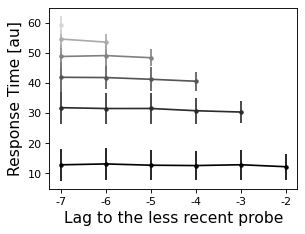

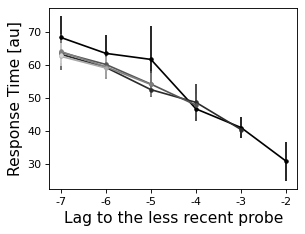

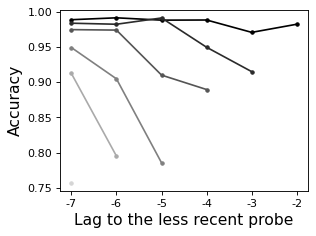

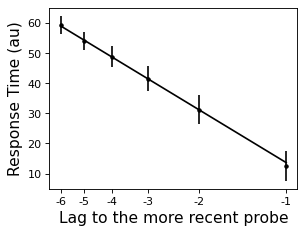

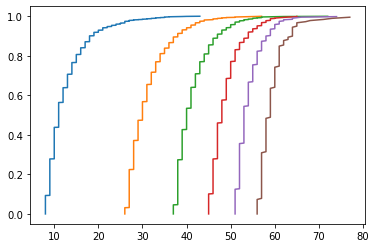

In [12]:
make_jor_flipped_figures(p_n)

In [13]:
import pickle
pickle.dump(p_n, open( "p_n_JOR-model.p", "wb" ) )